# AUDIO PROJECT 3 - MUSIC SYNCHRONIZATION #
## 1. Description ##

## 2. Implementation ##
### 2.1 Initialization ###

In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import librosa
import librosa.display
import sounddevice as sd

#### Load files and trim the silence part in each audio file

In [74]:
files = ["antti_yesterday.wav",
         "ferenc_yesterday.wav",
         "johanna_yesterday.wav",
         "outi_yesterday.wav"]
audio = []
fs = 0
hop_length = 1024
for f in files:
    signal,fs = librosa.load("../data/" + f)
    signal,index = librosa.effects.trim(signal)
    audio.append(signal)

<ipython-input-74-b6170a1fb51c>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio = np.array(audio)


#### Overview on given signal ####

Playing antti_yesterday
Size: 378880
Playing ferenc_yesterday
Size: 433664
Playing johanna_yesterday
Size: 418304
Playing outi_yesterday
Size: 407040


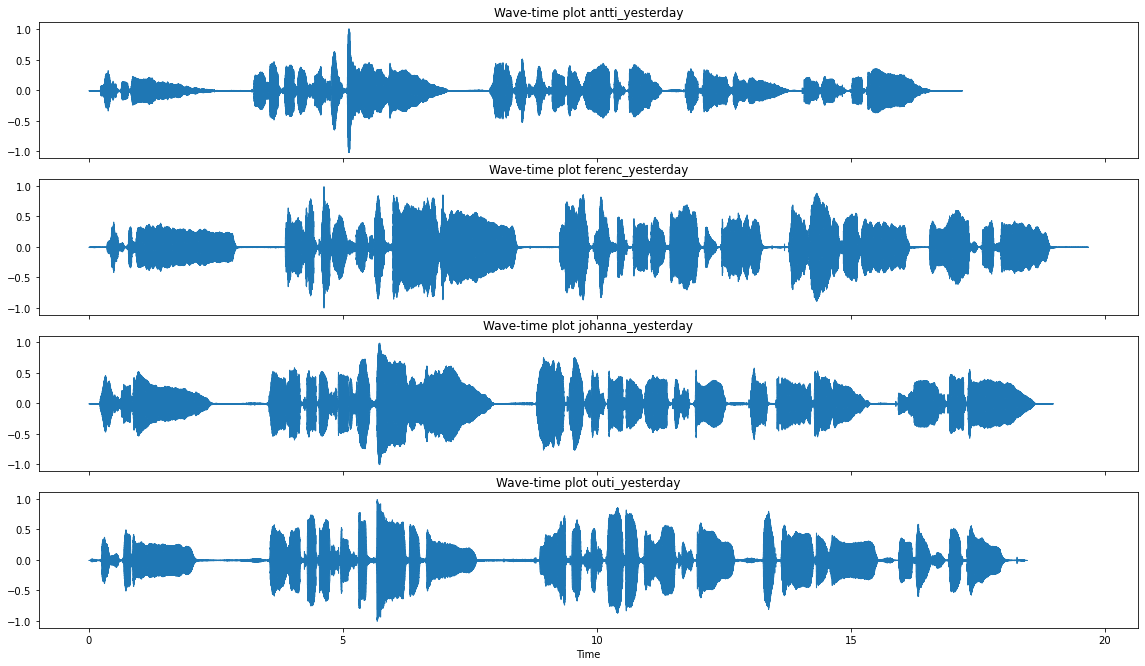

In [42]:
# Plot wave-time 4 signals - help function:
def plot_wave_time(signals,files,play_sound=False):
    fig, ax = plt.subplots(nrows=signals.__len__(),
                           sharex=True,
                           sharey=True,
                           figsize=(16,9))
    fig.tight_layout()
    for i,a in enumerate(signals):
        file_name = files[i].split('.')[0]
        print("Playing " + file_name)
        librosa.display.waveshow(a,sr=fs,ax=ax[i])
        ax[i].set(title="Wave-time plot " + file_name)
        ax[i].label_outer()
        if play_sound:
            sd.play(a,samplerate=fs,blocking="true")
        print("Size: " + str(a.size))

plot_wave_time(audio,files)

**Observation:**
- Audio signals have different lengths.
- The pattern in the audio signals (of the same music piece) are already recognizable.

**Decision**
- Time-stretch the last 3 signal based on the 1st <- DO WE NEED TO DO THIS STEP ?
- Stretch factor can be the ratio between signal's size


In [34]:
# stretched_signals = []
# for a in audio:
#     stretch_factor = a.size/audio[0].size
#     stretched_signal = librosa.effects.time_stretch(a,stretch_factor)
#     stretched_signals.append(stretched_signal)
# plot_wave_time(stretched_signals, files,play_sound=True)

**Comment:** The 3 later signals are shrinked down to the same size as the 1st signal, they
also heard a bit faster in pace.

### 2.2 Chroma features extract ###

In [43]:
# Help function to plot chroma presentation of signals
def plot_chroma(chroma,files):
    fig, ax = plt.subplots(nrows=chroma.__len__(),
                           sharex=True,
                           figsize=(16,9))
    fig.tight_layout()
    img = []
    for i,a in enumerate(chroma):
        file_name = files[i].split('.')[0]
        img = librosa.display.specshow(a,
                                 x_axis="time",
                                 y_axis="chroma",
                                 ax=ax[i])
        ax[i].set(title="Chroma representation of " + file_name)
        ax[i].label_outer()
    fig.colorbar(img,ax=ax)

### Chroma sequences alignment ###

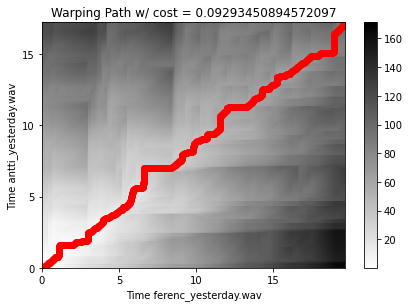

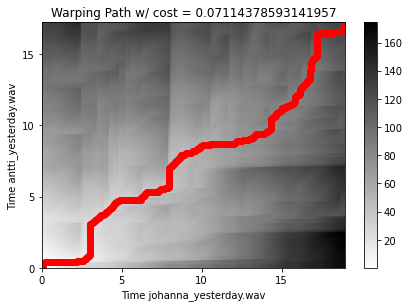

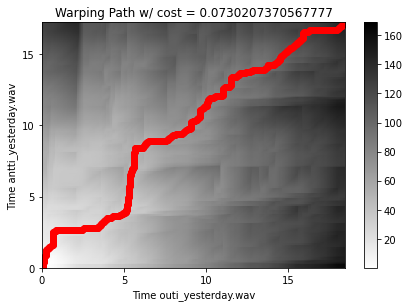

In [67]:
def plot_chroma_aligned(D,wp_s,cost,files):
    for i,file in enumerate(files[1:]):
        fig, ax = plt.subplots()
        fig.tight_layout()
        img = librosa.display.specshow(D[i], x_axis='time', y_axis='time', sr=fs,
                                       cmap='gray_r', hop_length=hop_length, ax=ax)
        ax.plot(wp_s[i][:, 1], wp_s[i][:, 0], marker='o', color='r')
        ax.set(title='Warping Path w/ cost = ' + str(cost[i]),
               xlabel='Time ' + files[i+1], ylabel='Time ' + files[0])
        fig.colorbar(img, ax=ax)

def perform_alignment(chroma, metric):
    cost = []
    D = []
    wp_s = []
    wp = []
    for i,c in enumerate(chroma[1:]):
        D_temp, wp_temp = librosa.sequence.dtw(X=chroma[0],Y=c,metric=metric)
        wp_s_temp = librosa.frames_to_time(wp_temp,sr=fs,hop_length=hop_length)
        D.append(D_temp)
        wp.append(wp_temp)
        wp_s.append(wp_s_temp)
        cost.append(D_temp[wp_temp[-1,0],wp_temp[-1,1]])
    return D,wp,wp_s,cost

chroma_cqt = []
for a in audio:
    chroma_cqt.append(librosa.feature.chroma_cqt(y=a,
                                             hop_length=hop_length,
                                             sr=fs,
                                             tuning=0,
                                             norm=2))

D, wp, wp_s, cost = perform_alignment(chroma_cqt,metric='cosine')
plot_chroma_aligned(D,wp_s, cost,files)

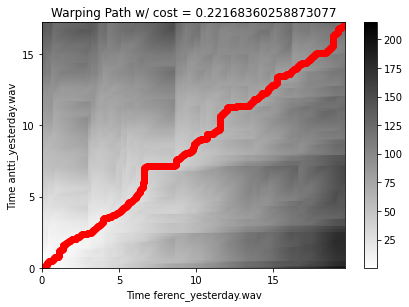

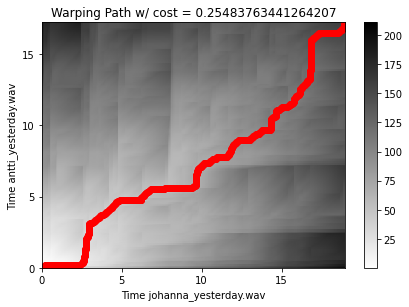

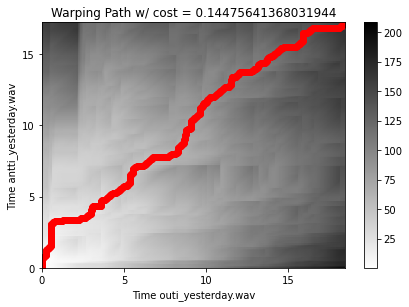

In [63]:
# N = 4410
# chroma_stft = []
# for a in audio:
#     chroma_stft.append(librosa.feature.chroma_stft(y=a,
#                                              hop_length=hop_length,
#                                              tuning=0,
#                                              sr=fs,
#                                              norm=2,
#                                              n_fft=N))
#
# D,wp, wp_s, cost = perform_alignment(chroma_stft,metric='cosine')
# plot_chroma_aligned(D,wp_s, cost,files)

### 2.3 Evaluate ###


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed